In [1]:
from data_utils import BotNetWrapper
from model_utils import GCN, train_model, epoch

import torch.nn as nn
import torch.optim as optim
import torch as ch
from tqdm import tqdm
import time
import os
import copy

import dgl.function as fn
from dgl.utils import expand_as_pair
from torch.nn import init
import time
from livelossplot import PlotLosses

Using backend: pytorch


In [2]:
epochs = 70
gpu = True

In [3]:
start = time.time()
ds = BotNetWrapper("adv", 1)
end = time.time()
print("Time taken to prepare data", end - start)

66
Time taken to prepare data 2.6967811584472656


In [4]:
print(len(ds.train_data))
print(len(ds.test_data))

58
8


In [5]:
batch_size = 1
lr = 0.005

train_loader, test_loader = ds.get_loaders(batch_size, shuffle=True)

In [6]:
model = GCN(n_inp=1, n_hidden=32, n_layers=6, dropout=0.0, residual=True)
model = model.cuda()

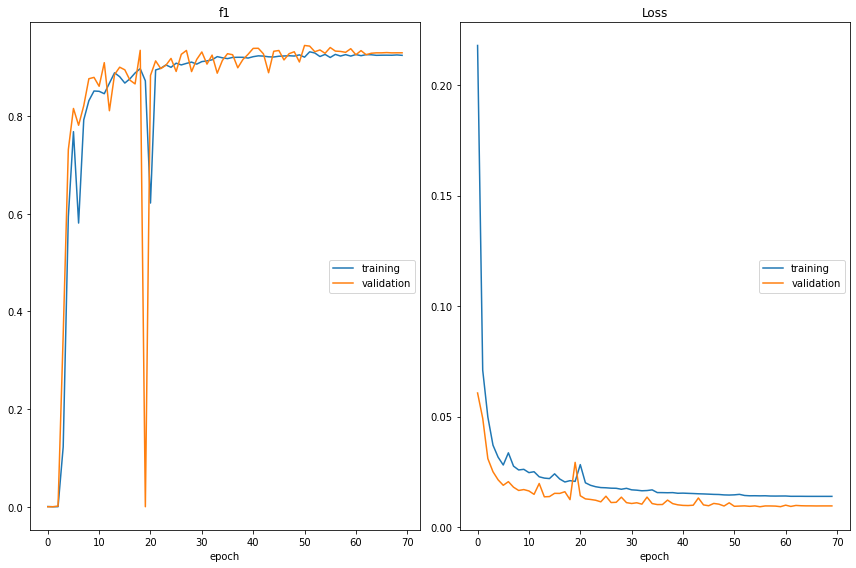

f1
	training         	 (min:    0.000, max:    0.932, cur:    0.924)
	validation       	 (min:    0.000, max:    0.945, cur:    0.930)
Loss
	training         	 (min:    0.014, max:    0.218, cur:    0.014)
	validation       	 (min:    0.009, max:    0.061, cur:    0.010)
Took 276.7472951412201 seconds


In [7]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
optimizer, mode='min', factor=0.25, patience=1)
plotlosses = PlotLosses()

iterator = range(epochs)
start = time.time()
for e in iterator:
    # Train
    model.train()
    tr_loss, tr_f1 = epoch(model, train_loader, gpu, optimizer, verbose=False)

    model.eval()
    te_loss, te_f1 = epoch(model, test_loader, gpu, None, verbose=False)

    # Scheduler step
    scheduler.step(tr_loss)
    
    # Plot metrics
    plotlosses.update({
        'loss': tr_loss,
        'val_loss': te_loss,
        'f1': tr_f1,
        'val_f1': te_f1
    })
    plotlosses.send()
end = time.time()

print("Took", end-start, "seconds")

In [8]:
# bs=1: 277s
# bs=2 : 218s
# bs=4 : 237s
# bs=8: 197s (unstable)
# bs=16: 214s